# **Costa Rica - Seizure and Homicide Data Analysis**
#### InSight Crime - MAD Unit 
June, 2025


---------------------



### Project Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/costa-rica-presentation](https://github.com/FelipeVillota/costa-rica-presentation)). I keep the repository `private` with the possibility to give collaborator-access to the online repo at any time. 

#### Reproducible Environment

In [ ]:
# IMPORTANT

# In the Terminal, run the following commands to set up a virtual environment called `venv-cr`:
# python -m venv venv-cr

# To activate environment, run (the first is an optional, temporary auth) :
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass
# venv-cr\Scripts\activate

# Then select respective kernel 

# Update list master list
# pip freeze > requirements.txt

In [1]:
# Checking venv-db-watch works --> accept to install ipykernel package to connect to kernel if asked
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\costa-rica\costa-rica-presentation\venv-cr\Scripts\python.exe


#### Loading Libraries

In [ ]:
# Install the required packages in the virtual environment:
# pip install --upgrade pip
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas
# pip install gspread gspread-formatting seaborn matplotlib missingno    

In [7]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from io import BytesIO


# pip freeze > requirements.txt

### Loading Data

In [19]:
# Use raw GitHub URLs
url_homicidios = "https://github.com/FelipeVillota/costa-rica-presentation/raw/main/data/raw/CR-homicidios-dolosos-2010-2024.xlsx"
url_control_ods = "https://github.com/FelipeVillota/costa-rica-presentation/raw/main/data/raw/Control_de_la_Oferta_ODS_SW1.xlsx"

# Get file content
response1 = requests.get(url_homicidios)
response2 = requests.get(url_control_ods)

In [ ]:
# Load all sheets from each Excel file as separate DataFrames
homicidios_sheets = pd.read_excel(BytesIO(response1.content), engine='openpyxl', sheet_name=None)
control_ods_sheets = pd.read_excel(BytesIO(response2.content), engine='openpyxl', sheet_name=None)

# Now there are dictionaries where keys are sheet names and values are DataFrames
# 
first_homicidios_sheet = list(homicidios_sheets.values())[0]
control_ods_sheet_8 = list(control_ods_sheets.values())[0]


In [21]:

# Preview first sheet from each file
print("First sheet from homicidios file:")
print(first_homicidios_sheet.head())

print("\nFirst sheet from control_ods file:")
print(first_control_ods_sheet.head())

# If you want to work with all sheets, you can iterate through them:
print("\nAll sheets in homicidios file:")
for sheet_name, df in homicidios_sheets.items():
    print(f"Sheet: {sheet_name}")
    print(df.head())
    print("-----")

print("\nAll sheets in control_ods file:")
for sheet_name, df in control_ods_sheets.items():
    print(f"Sheet: {sheet_name}")
    print(df.head())
    print("-----")

First sheet from homicidios file:
   Unnamed: 0 Unnamed: 1
0         NaN        NaN
1         NaN        NaN
2         NaN        NaN
3         NaN        NaN
4         NaN        NaN

First sheet from control_ods file:
   Unnamed: 0 Unnamed: 1
0         NaN        NaN
1         NaN        NaN
2         NaN        NaN
3         NaN        NaN
4         NaN        NaN

All sheets in homicidios file:
Sheet: Índice
   Unnamed: 0 Unnamed: 1
0         NaN        NaN
1         NaN        NaN
2         NaN        NaN
3         NaN        NaN
4         NaN        NaN
-----
Sheet: 1
  1.Plantaciones de cannabis según ubicación geográfica. 2010-2024 Unnamed: 1  \
0                                              Fecha                Provincia   
1                                2022-05-31 00:00:00                  Cartago   
2                                2022-09-22 00:00:00                  Heredia   
3                                2022-03-10 00:00:00                  Heredia   
4             

### Execution

#### Pre-processing

In [8]:
# Handle Missing/Invalid Values
 
df = df.replace('', pd.NA)  # Convert empty strings to NA
df = df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


### Exploratory Data Analysis

##### Summary Stats

In [10]:
def get_dataframe_summary(df):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{df.shape[0]} rows × {df.shape[1]} cols",
        "Memory Usage": f"{df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB",
        "Columns with NA": f"{df.isna().any().sum()} / {len(df.columns)}",
        "Duplicate Rows": f"{df.duplicated().sum()} ({(df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{df.select_dtypes(include='number').shape[1]}",
        "Categorical Columns": f"{df.select_dtypes(include=['object', 'category']).shape[1]}",
        "Datetime Columns": f"{df.select_dtypes(include='datetime').shape[1]}"
    }

  # --- Compute dropdown options per column ---
    dropdown_options_dict = {
        col: dropdown_options.get(col, [])
        for col in df.columns
    }
    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': df.columns,
        'Dtype': df.dtypes.values,
        'Unique_Count': df.nunique().values,
        'NA_Count': df.isna().sum().values,
        'NA_Percentage': (df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': df.apply(lambda x: x.drop_duplicates().tolist()).values,
        'Dropdown_Options': [dropdown_options_dict[col] for col in df.columns],
        'Dropdown_Option_Count': [len(dropdown_options_dict[col]) for col in df.columns]
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'

    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(df)

# Print General Info
print("=== GENERAL DATAFRAME INFO ===")
for key, value in general_info.items():
    print(f"{key}: {value}")

# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS ===")
display(column_stats)


=== GENERAL DATAFRAME INFO ===
Shape: 419 rows × 41 cols
Memory Usage: 1.07 MB
Columns with NA: 37 / 41
Duplicate Rows: 0 (0.0%)
Numeric Columns: 0
Categorical Columns: 41
Datetime Columns: 0

=== COLUMN-LEVEL STATISTICS ===


,Variable,Dtype,Unique_Count,NA_Count,NA_Percentage,Duplicate_Count,Duplicate_Percentage,Unique_Values,Dropdown_Options,Dropdown_Option_Count
35,Description,object,416,1,0.2%,4,1.0%,"[Spanish citizen, coming from Lisbon , was sto...",[],0
39,Source link,object,400,1,0.2%,33,7.9%,[https://www.lanazione.it/firenze/cronaca/coca...,[],0
9,Quantity,object,284,3,0.7%,202,48.2%,"[10, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 55...",[],0
17,Municipality/Port,object,264,110,26.3%,187,44.6%,"[Florence, Santo Domingo, Lake Maracaibo , Eag...",[],0
16,Department/State,object,219,36,8.6%,268,64.0%,"[<NA>, Zulia, Texas, Cáceres, Azores, Québec, ...",[],0
11,seizure_kgs,object,217,122,29.1%,250,59.7%,"[9, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 250...",[],0
2,Date,object,94,2,0.5%,402,95.9%,"[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1...",[],0
24,Transit 1/Municipality,object,72,333,79.5%,358,85.4%,"[<NA>, Matapalo, Rio de Janeiro, Acapulco, Kin...",[],0
23,Transit 1/Department,object,61,321,76.6%,370,88.3%,"[Lisbon, <NA>, Santo Domingo, Paris, Puntarena...",[],0
15,Country,object,50,3,0.7%,399,95.2%,"[Italy, Dominican Republic, Venezuela, United ...",[],0


##### Missing Data Analysis


Missing values per column:
Type                                 0
Time unit                            0
Date                                 2
Date 2                             408
Year                                 2
Month                                2
Day                                  3
Duration                           407
Type Drugs                           0
Quantity                             3
Weight unit                          2
seizure_kgs                        122
Modus Operandi/place of seizure      7
Sub MO                             389
Region                               0
Country                              3
Department/State                    36
Municipality/Port                  110
Origin country                     363
Origin Area                        397
Origin municipality                405
Transit 1/Region                   263
Transit 1/country                  250
Transit 1/Department               321
Transit 1/Municipality             33

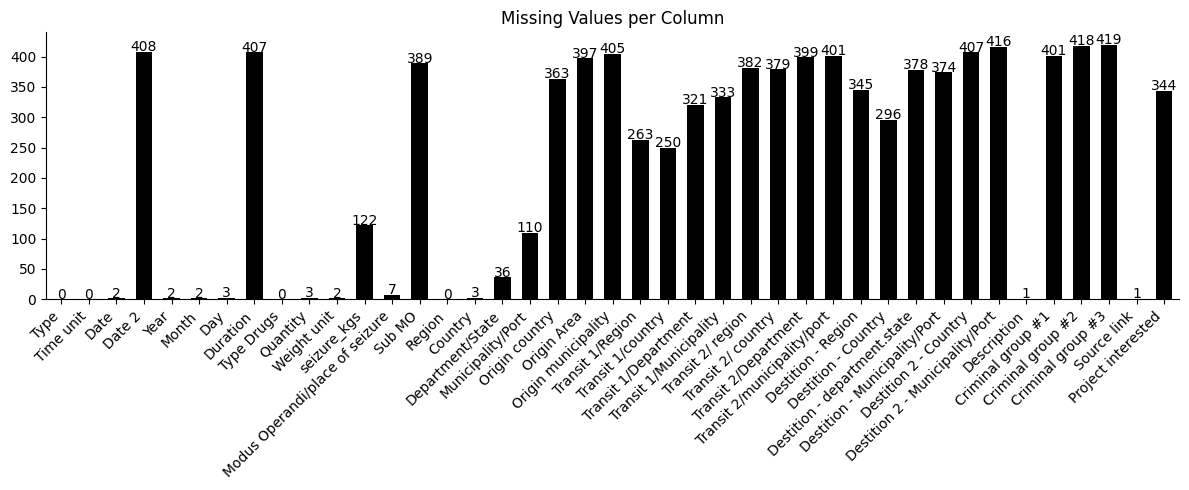

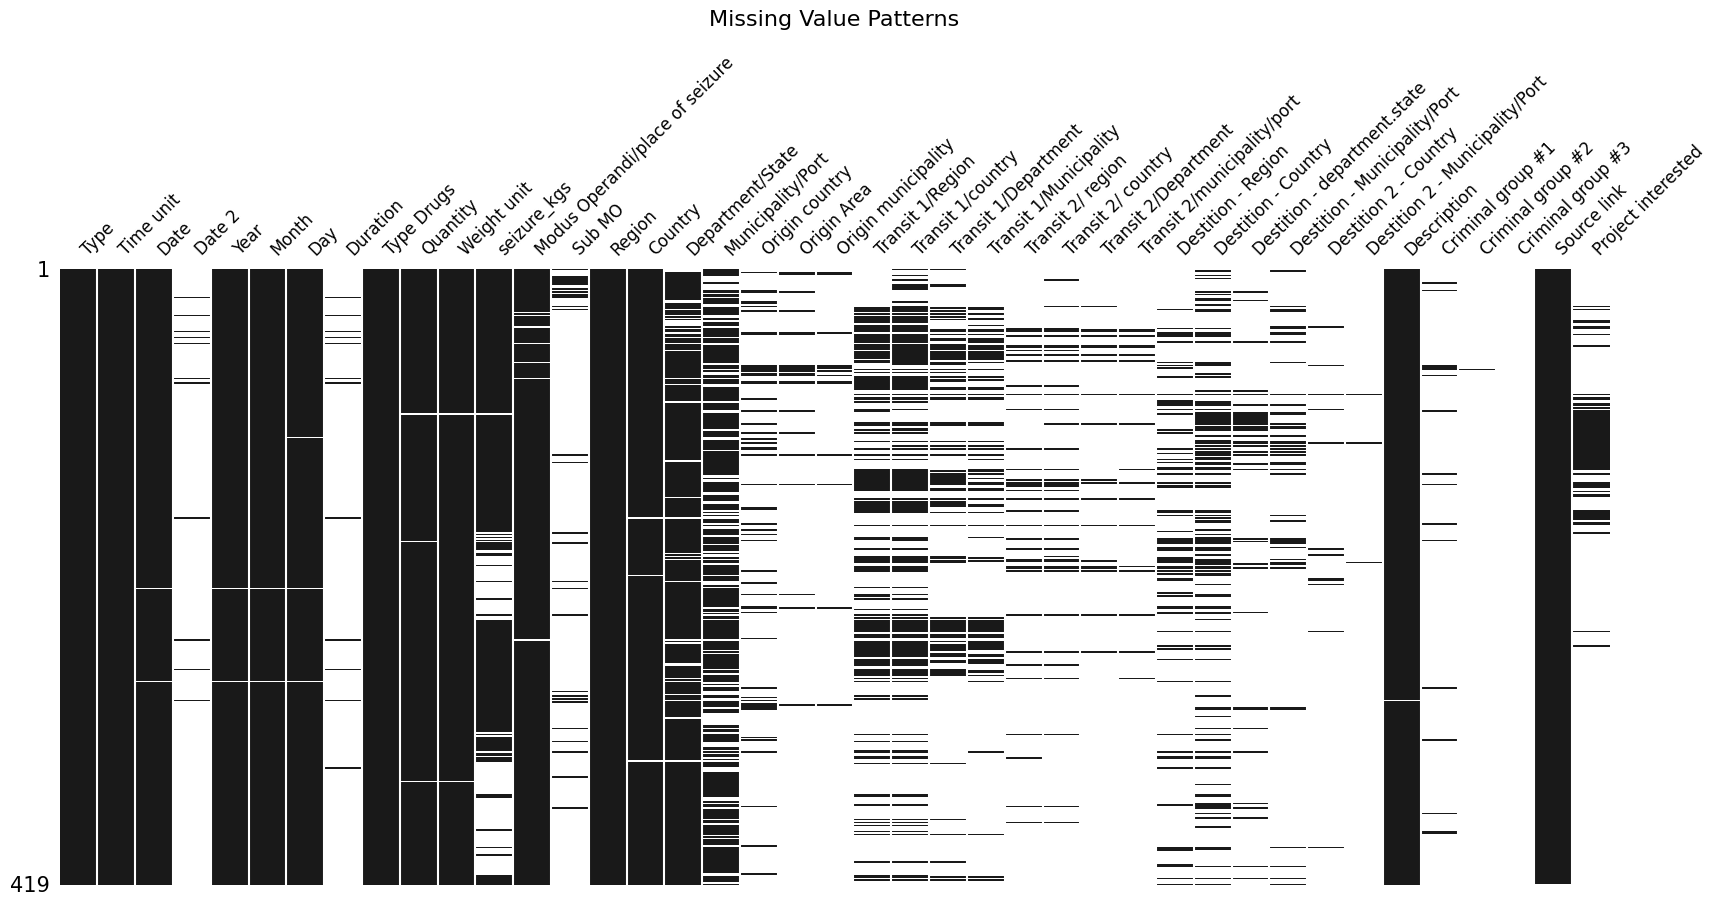

In [11]:

missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}\n")

# Visualization 1: Bar Chart
plt.figure(figsize=(12, 5))
ax = missing_values.plot(kind='bar', color="#000000", width=0.6)
ax.grid(False)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+1, 
            f'{int(i.get_height())}', 
            ha='center', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()

# Visualization 2: Missingno Matrix
msno.matrix(
    df,
    figsize=(20, 8),
    color=(0.1, 0.1, 0.1),
    sparkline=False,
    fontsize=12,
    labels=True
)
plt.title("Missing Value Patterns", fontsize=16, pad=20)
plt.show()

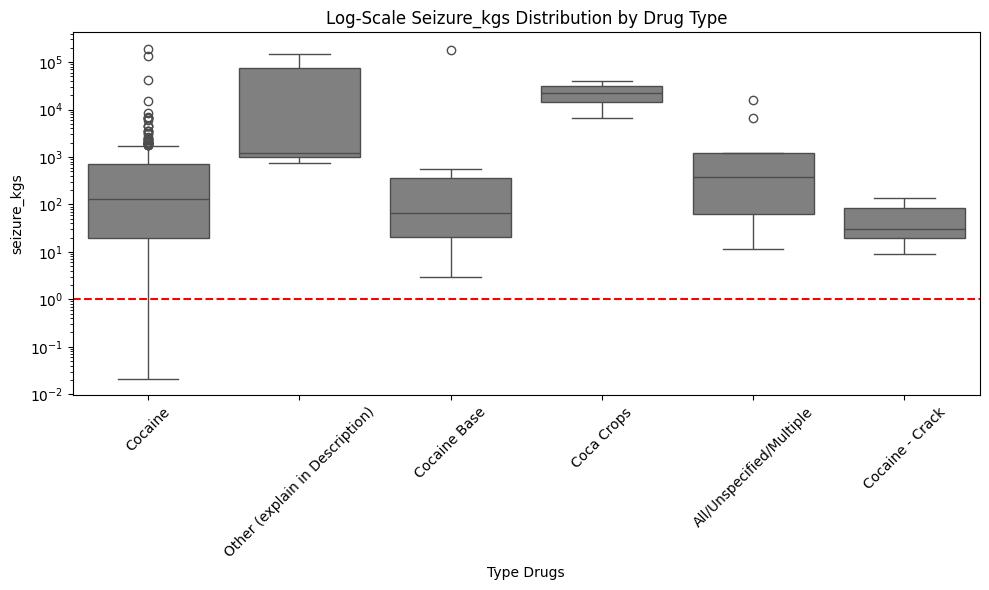

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Boxplot with grey boxes
sns.boxplot(data=df, x='Type Drugs', y='seizure_kgs', color='grey')

# Log scale on y-axis
plt.yscale('log')

# Red horizontal line at y=1 (which is 10^0)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)

plt.title("Log-Scale Seizure_kgs Distribution by Drug Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

